# Day 11: Guiding Decisions with Optimization

---

Let's talk about how we can use the optimization ideas we've seen so far to help guide design decisions:

- Multiple objectives
  - Pareto frontier as "menu"; use supporting information
  - Oar materials revisited:
    - Why not rigid foams?
    - Why not technical ceramics?
- Constraints


In [4]:
import pandas as pd 
import grama as gr 
import numpy as np
from plotnine import *
DF = gr.Intention()


# Multiple Objectives

---

## Recall: Oar material selection

---

Remember that we eliminated "Rigid polymer foams"; why?


![ashby plot](./images/ashby-fig6.2.png)


### Why not technical ceramics?

Ceramics are brittle; they fracture easily (compared to wood and CFRP).


### Why not rigid foams?

For one thing, rigid foams have low toughness, but there's another reason we should discount them.

Let's use our optimal radius:

$$r^* = \left( \frac{4}{3\pi} \frac{FL^3}{E} \frac{1}{\delta_{\max}} \right)^{1/4}$$

So the ratio between the optimal radius for different materials---all else but $E$ equal---would be:

$$r_1 / r_2 = (E_2 / E_1)^{1/4}$$

Note that $E_{\text{wood}} / E_{\text{foam}} \approx 10^2$, thus

$$r_{\text{foam}} = 10^{1/2} r_{\text{wood}} \approx 3 r_{\text{wood}}$$

or $A_{\text{foam}} = 10 A_{\text{wood}}$. This would be rather unwieldy, plus real rowers are unlikely to buy these because they'd look comical. There would probably be drag concerns as well.

**Conclusion**: Maybe we were missing a constraint; a maximum radius.


## Exchange constants

---

We talked about the *weight method* to identify individual points on the Pareto frontier. By using a variety of weights, you can sketch-out a Pareto frontier by finding individual non-dominated points.

One way we can choose a *single* set of weights is to compute [exchange coefficients](https://www.sciencedirect.com/topics/engineering/exchange-constant); these represent the rate at which we would "exchange" one objective for another.

### Example exchange constants: US Dollars for Mass

One easy-to-understand case of an exchange coefficient is money for mass. Using problem-specific knowledge, it's often possible to *estimate* the cost associated with a unit of mass. For the following transportation categories, a different Basis was used to estimate the cost of having an additional kilogram of mass in the vehicle structure.

| Sector | Basis | Exchange (USD / kg) |
|---|---|---|
| Family car | Fuel savings | 1-2 |
| Truck | Payload | 5-20 |
| Civil aircraft | Payload | 100-500 |
| Military aircraft | Payload/performance | 500-1,000 |
| Spacecraft | Payload | 3,000-10,000 |

Adapted from Table 9.2 in Ashby (1994)


Let's look at an example; suppose we have the following profit vs mass relationship. Clearly we want

$$\max\, \text{Profit}$$
$$\min\, \text{Mass}$$


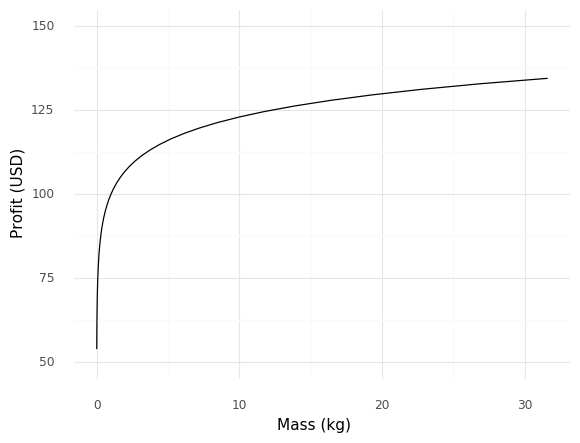

<ggplot: (8769230936113)>

In [79]:
md_cost = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            mass=df.x * 1,
            profit=(np.log(df.x) + 10) * 10,
        ),
        var=["x"],
        out=["mass", "profit"]
    )
    >> gr.cp_bounds(x=(1e-3, 1e2))
)

(
    md_cost
    >> gr.ev_df(df=gr.df_make(x=np.logspace(-2, 1.5)))
    
    >> ggplot(aes("mass", "profit"))
    + geom_line()
    
    + coord_cartesian(ylim=(50, 150))
    + theme_minimal()
    + labs(
        x="Mass (kg)",
        y="Profit (USD)",
    )
)

Set a specific exchange coefficient to pick a particular point on the Pareto frontier.


          x      x_0     out_net      profit      mass  success  \
0  9.999948  50.0005 -113.025851  123.025799  9.999948     True   

                                 message  n_iter  
0  Optimization terminated successfully.      13  


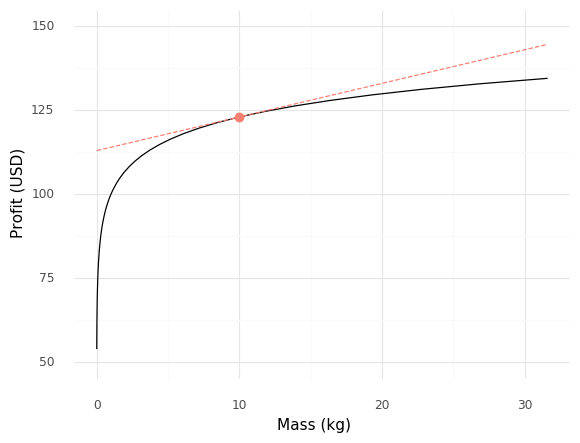

<ggplot: (8769230905965)>

In [78]:
# Set the exchange coefficient
m2c = 1 # Family car
# m2c = 10 # Truck
# m2c = 100 # Civil aircraft
# m2c = 1e3 # Military aircraft
# m2c = 1e4 # Spacecraft

# Solve minimization with selected weight
df_opt = (
    md_cost
    >> gr.cp_function(
        fun=lambda df: gr.df_make(
            # min -profit -> max profit
            # min m2c * mass -> min cost of mass
            out_net = -df.profit + m2c * df.mass
        ),
        var=["profit", "mass"],
        out=["out_net"]
    )
    
    >> gr.ev_min(out_min="out_net")
)
print(df_opt)

# Compute tangent line
profit0 = float(df_opt.profit[0] - m2c * df_opt.mass[0])
df_tangent = (
    gr.df_make(mass=np.logspace(-2, +1.5))
    >> gr.tf_mutate(profit=profit0 + m2c * DF.mass)
)

# Visualize
(
    md_cost
    >> gr.ev_df(df=gr.df_make(x=np.logspace(-2, 1.5)))
    
    >> ggplot(aes("mass", "profit"))
    + geom_line()
    # Annotation layers
    + geom_line(
        data=df_tangent,
        linetype="dashed",
        color="salmon",
    )
    + geom_point(
        data=df_opt,
        color="salmon",
        size=3,
    )
    
    + coord_cartesian(ylim=(50, 150))
    + theme_minimal()
    + labs(
        x="Mass (kg)",
        y="Profit (USD)",
    )
)

# References

- Ashby *Materials Selection in Mechanical Design* (1994), 3rd Edition.